# Renforcement Learning with Super Mario Bros
## Author: Elias Nicolas

### Setup

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import sys
import gym

In [2]:
print(f"Python Executable: {sys.executable}")
print(f"Gym Version: {gym.__version__}")

Python Executable: /opt/anaconda3/envs/mario/bin/python
Gym Version: 0.21.0


In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [5]:
env.action_space

Discrete(7)

In [6]:
env.observation_space.shape

(240, 256, 3)

In [ ]:
done = True
##Loops through the game frames
for frame in range (100000):
    ##Start the game to begin with
    if done:
        ##Starts our game
        env.reset()
    ##Random actions
    state, reward, done, info = env.step(env.action_space.sample())
    ##Show the game
    env.render()
env.close()

In [7]:
state = env.reset()
state.shape

(240, 256, 3)

In [8]:
env.step(1)[1]

0.0

### Preprocessing

In [9]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [10]:
##Grayscale the env
env = GrayScaleObservation(env, keep_dim=True)

##Wrap in a dummy enviorment 
env = DummyVecEnv([lambda : env])

##Stack our frames
env = VecFrameStack(env,4,channels_order='last')

In [11]:
##Put in an array since we are now vectorizing our enviorment
state, reward, done, info = env.step([env.action_space.sample()])

In [12]:
##Jumping is index number 5 in our SIMPLE_MOVEMENT list
SIMPLE_MOVEMENT[5]

['A']

In [13]:
state = env.reset()
state.shape

(1, 240, 256, 4)

In [18]:
##Show the frames in which Mario is jumping 
state, reward, done, info = env.step([5])

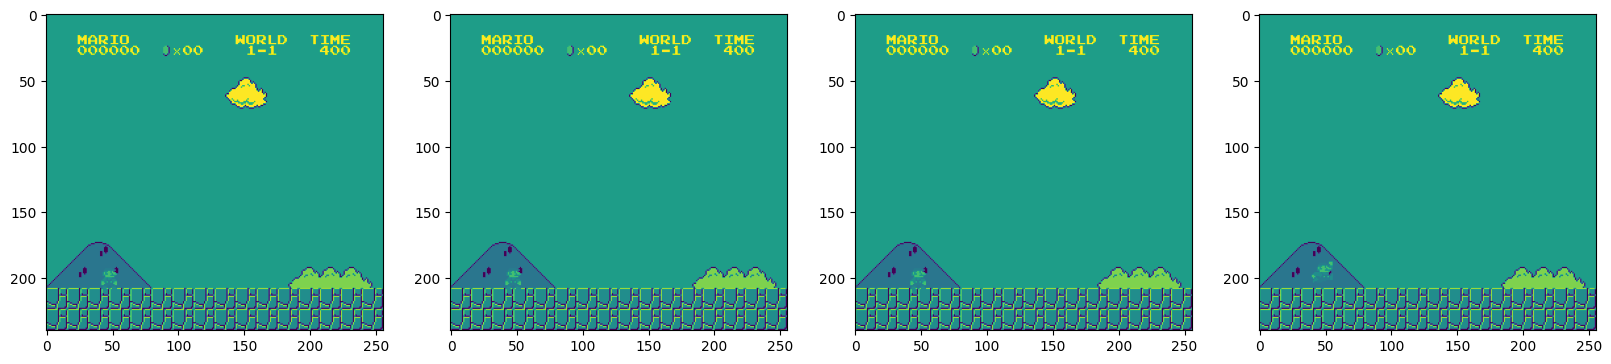

In [19]:
plt.figure(figsize=(20,16))
for ind in range (state.shape[3]):
    plt.subplot(1,4,ind+1)
    plt.imshow(state[0][:,:,ind])
plt.show()

### Training the Model

In [20]:
import os 
##I will be using the Proximal Policy Optimization Reinforcement Learning model 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [21]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [22]:
CHECKPOINT_DIR = '/Volumes/Mario/train/'
LOG_DIR = '/Volumes/Mario/log/'

In [23]:
callback = TrainAndLoggingCallback(check_freq=50000,save_path=CHECKPOINT_DIR)

In [24]:
model = PPO('CnnPolicy',env,verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=1000000, callback=callback)

In [27]:
model = PPO.load('/Volumes/Mario/train/best_model_400000.zip')

/opt/anaconda3/envs/mario/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_conte

In [29]:
state = env.reset()
while True: 
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 